# Calibración de clasificadores

## Importación de librerias y creación de funciones

In [215]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score,log_loss,brier_score_loss

In [216]:
def load_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [217]:
def load_pkl(ruta):
    
    with open(ruta, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [218]:
def load_validation_data(ruta_csv):
    df=load_csv(ruta_csv)
    independent_var_erase=[''] # Eliminamos la variable de precipitacion acumulada a los 10 dias
    dependent_var='deslizamientos'
    independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]
    X=df[independent_var]
    y=df[dependent_var]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=23)
    return X_valid, y_valid

In [219]:
def load_models(ruta_m):
    ruta_modelos=ruta_m
    modelos=[archivo for archivo in os.listdir(ruta_modelos) if os.path.isfile(os.path.join(ruta_modelos, archivo))]

    dict_modelos={}
    for modelo in modelos:
        pkl=load_pkl(os.path.join(ruta_modelos,modelo))
        key=modelo.split('.')[0]
        dict_modelos[key]=pkl

    rf=dict_modelos['random-forest-model']
    xgb=dict_modelos['xgboosted-trees-model']
    lr=dict_modelos['logistic-regressor-model']
    svc=dict_modelos['svc-model']

    return rf,xgb,lr,svc

In [220]:
def preprocess_data(encoder,df):
    columns_to_encode=list(encoder.keys())
    df2=df.copy()
    for column in columns_to_encode:
        array=encoder[column].transform(df2[column])
        df2[column]=array
    
    return df2

In [221]:
def validation_model_performance(ruta_m,ruta_csv):
    rf,xgb,lr,svc=load_models(ruta_m)
    X_valid, y_valid=load_validation_data(ruta_csv)

    # RF
    model_rf=rf['modelo']
    encoder_rf=rf['encoder']

    X_valid_rf=preprocess_data(encoder_rf,X_valid)
    X_valid_rf=X_valid_rf.drop(columns=['10d'])

    y_pred_rf = model_rf.predict(X_valid_rf)
    precision_rf = precision_score(y_valid, y_pred_rf)
    accuracy_rf = accuracy_score(y_valid, y_pred_rf)
    recall_rf = recall_score(y_valid, y_pred_rf)
    f1_rf = f1_score(y_valid, y_pred_rf)

    # XGBoost
    model_xgb=xgb['modelo']
    encoder_xgb=xgb['encoder']

    X_valid_xgb=preprocess_data(encoder_xgb,X_valid)
    X_valid_xgb=X_valid_xgb.drop(columns=['10d'])

    y_pred_xgb = model_xgb.predict(X_valid_xgb)
    precision_xgb = precision_score(y_valid, y_pred_xgb)
    accuracy_xgb = accuracy_score(y_valid, y_pred_xgb)
    recall_xgb = recall_score(y_valid, y_pred_xgb)
    f1_xgb = f1_score(y_valid, y_pred_xgb)

    # Logistic Reg
    model_lr=lr['modelo']
    encoder_lr=lr['encoder']

    X_valid_lr=preprocess_data(encoder_lr,X_valid)
    X_valid_lr=X_valid_lr.drop(columns=['7d','15d','60d'])

    y_pred_lr = model_lr.predict(X_valid_lr)
    precision_lr = precision_score(y_valid, y_pred_lr)
    accuracy_lr = accuracy_score(y_valid, y_pred_lr)
    recall_lr = recall_score(y_valid, y_pred_lr)
    f1_lr = f1_score(y_valid, y_pred_lr)

    # SVC
    model_svc=svc['modelo']
    encoder_svc=svc['encoder']

    X_valid_svc=preprocess_data(encoder_svc,X_valid)
    X_valid_svc=X_valid_svc.drop(columns=['10d'])

    y_pred_svc = model_svc.predict(X_valid_svc)
    precision_svc = precision_score(y_valid, y_pred_svc)
    accuracy_svc = accuracy_score(y_valid, y_pred_svc)
    recall_svc = recall_score(y_valid, y_pred_svc)
    f1_svc = f1_score(y_valid, y_pred_svc)

    #####
    data_reporte = {
        'Modelo': ['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regressor','Support Vector Classifer'
                   ],
        'Precision': [precision_rf,precision_xgb,precision_lr,precision_svc
                      ],
        'Recall': [recall_rf,recall_xgb,accuracy_lr,accuracy_svc
                   ],
        'Exactitud': [accuracy_rf,accuracy_xgb,recall_lr,recall_svc
                      ],
        'F1-score': [f1_rf,f1_xgb,f1_lr,f1_svc
                     ]
    }

    df_reporte = pd.DataFrame(data_reporte)
    return df_reporte

In [222]:
# Función para calcular el Expected Calibration Error (ECE)
def calculate_ece(y_true, y_prob, fraction_of_positives,mean_predicted_value,n_bins=8):
    bin_sizes = np.histogram(y_prob, bins=n_bins)[0]
    total_samples = len(y_true)
    
    ece = np.sum((bin_sizes / total_samples) * np.abs(mean_predicted_value - fraction_of_positives))
    return ece

## Revisión de Modelos

Recapitulando, se muestra el comportamiento de los mejores modelos selectos durante el proceso de validación cruzada, en la siguiente tabla se proyectan sus rendimientos en la etapa de entrenamiento y de prueba.

| Modelo | Rendimiento en Train (Precision) | Rendimiento en Test (Precision) |
| --------- | --------- | --------- |
| Random Forest Classifier    | 0.99903    | 0.92842    |
| Gradient Boosting Classifier    | 1.0    | 0.96009    |
| Logistic Regressor    | 0.91033    | 0.90531    |
| Support Vector Classifer    | 0.95424    | 0.92172    |

Como podemos observar, todos los modelos usados se ajustan bastante bien a la data de entrenamiento. En estos casos se puede tomar la decisión del mejor modelo a usar dependiendo de otros aspectos, por ejemplo, el tiempo de entrenamiento, el recurso computacional consumido, la versatilidad del modelo y que tan calibrado está, esto último lo revisaremos con detalle más adelante.


Veamos ahora como les fue con data de validación, la cual nunca habían visto durante el entrenamiento y prueba:

In [223]:
df_reporte=validation_model_performance(os.path.join('..','Models','output'),os.path.join('..','Data','output','train_data_1.csv'))
df_reporte

,Modelo,Precision,Recall,Exactitud,F1-score
0,Random Forest Classifier,0.908257,0.961165,0.926316,0.933962
1,Gradient Boosting Classifier,0.934579,0.970874,0.947368,0.952381
2,Logistic Regressor,0.920000,0.900000,0.893204,0.906404
3,Support Vector Classifer,0.913978,0.863158,0.825243,0.867347


En la función anterior, evaluamos cada modelo con data de validación, vemos en la tabla todos los modelos tuvieron buenos puntajes con data que nunca habían visto, lo que nos da indicios de que se ajusta bien a nuestra data de entrenamiento y son bueno para clasificar. 


Ahora debemos validar si están bien calibrados o no. 

## Validación de calibración para los clasificadores

Como ya se habia explicado anteriormente, usaremos los 3 metodos explicados en la sección de [Calibradores de probabilidad](intro.md#calibradores-de-probabilidad), empezaremos analizando la curva de calibración

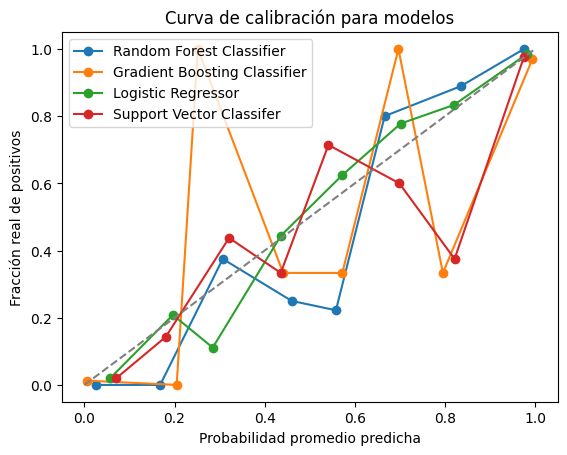

In [224]:
rf,xgb,lr,svc=load_models(os.path.join('..','Models','output'))
X_valid, y_valid=load_validation_data(os.path.join('..','Data','output','train_data_1.csv'))

# RF
model_rf=rf['modelo']
encoder_rf=rf['encoder']

X_valid_rf=preprocess_data(encoder_rf,X_valid)
X_valid_rf=X_valid_rf.drop(columns=['10d'])

# XGBoost
model_xgb=xgb['modelo']
encoder_xgb=xgb['encoder']

X_valid_xgb=preprocess_data(encoder_xgb,X_valid)
X_valid_xgb=X_valid_xgb.drop(columns=['10d'])

# Logistic Reg
model_lr=lr['modelo']
encoder_lr=lr['encoder']

X_valid_lr=preprocess_data(encoder_lr,X_valid)
X_valid_lr=X_valid_lr.drop(columns=['7d','15d','60d'])

# SVC
model_svc=svc['modelo']
encoder_svc=svc['encoder']

X_valid_svc=preprocess_data(encoder_svc,X_valid)
X_valid_svc=X_valid_svc.drop(columns=['10d'])

# Obtener las probabilidades predichas
y_pred_rf = model_rf.predict_proba(X_valid_rf)[:, 1]
y_pred_xgb = model_xgb.predict_proba(X_valid_xgb)[:, 1] 
y_pred_lr = model_lr.predict_proba(X_valid_lr)[:, 1]
y_pred_svc = model_svc.predict_proba(X_valid_svc)[:, 1] 

# Obtener las curvas de calibración
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_valid, y_pred_rf, n_bins=8,strategy='uniform') # strategy{‘uniform’, ‘quantile’}
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_valid, y_pred_xgb, n_bins=8,strategy='uniform')
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_valid, y_pred_lr, n_bins=8,strategy='uniform')
fraction_of_positives_svc, mean_predicted_value_svc = calibration_curve(y_valid, y_pred_svc, n_bins=8,strategy='uniform')

# Graficar todas las curvas
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Random Forest Classifier')
plt.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', label='Gradient Boosting Classifier')
plt.plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', label='Logistic Regressor')
plt.plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', label='Support Vector Classifer')

# Graficar la línea ideal de calibración
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Etiquetas y leyenda
plt.xlabel('Probabilidad promedio predicha')
plt.ylabel('Fracción real de positivos')
plt.title('Curva de calibración para modelos')
plt.legend(loc='best')  # Agregar la leyenda para identificar cada modelo

# Mostrar la gráfica
plt.show()

En la siguiente gráfica de ejemplo, podemos ver el eje X (Mean predicted value) representa las probabilidades predichas por cada uno de los modelos, va de 0 a 1, indicando la confianza con la que los modelos estiman la existencia de deslizamientos de tierra (clase positiva). Respecto al eje Y (Fraction of positives) muestra la fracción de positivos reales, es decir, la proporción de veces que un evento predicho como probable en realidad ocurre en el conjunto de datos.
Todas las series serán comparadas con una línea que representa el caso de calibración perfecta. Si un modelo está perfectamente calibrado, los puntos de su curva se alinearán con esta diagonal, indicando que las probabilidades predichas coinciden con las frecuencias observadas de los deslizamientos de tierra reales. Por ejemplo, una predicción de deslizamiento de tierra de 0.6 significaría que en el 60% de los casos ese evento ocurre realmente.


Dicho esto, y al ver la gráfica, el `Logistic Regressor` parece ser el mejor calibrado para estimar probabilidades, seguido por el `Support Vector Classifer`, que son los que más se ajustan a la línea diagonal 'ideal'. El `Gradient Boosting Classifier` también se comporta razonablemente bien, mientras que el `Random Forest Classifier` es el que menos confiable es en cuanto a la calibración de probabilidades.

Ahora, calculemos los indicadores expuestos y explicados en la sección de [Calibradores de probabilidad](intro.md#calibradores-de-probabilidad)

In [225]:
# Calcular log loss y Brier score
logloss_rf = log_loss(y_valid, y_pred_rf)
brier_rf = brier_score_loss(y_valid, y_pred_rf)

logloss_xgb = log_loss(y_valid, y_pred_xgb)
brier_xgb = brier_score_loss(y_valid, y_pred_xgb)

logloss_lr = log_loss(y_valid, y_pred_lr)
brier_lr = brier_score_loss(y_valid, y_pred_lr)

logloss_svc = log_loss(y_valid, y_pred_svc)
brier_svc = brier_score_loss(y_valid, y_pred_svc)

# Calcular ECE para cada caso
ece_rf = calculate_ece(y_valid, y_pred_rf,fraction_of_positives_rf,mean_predicted_value_rf)
ece_xgb = calculate_ece(y_valid, y_pred_xgb,fraction_of_positives_xgb,mean_predicted_value_xgb)
ece_lr = calculate_ece(y_valid, y_pred_lr,fraction_of_positives_lr,mean_predicted_value_lr)
ece_svc = calculate_ece(y_valid, y_pred_svc,fraction_of_positives_svc,mean_predicted_value_svc)

# Agregar resultados a la lista
indicators={'Classifier': ['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regressor','Support Vector Classifer'],
            'ECE': [ece_rf,ece_xgb,ece_lr,ece_svc],
            'Brier Score': [brier_rf,brier_xgb,brier_lr,brier_svc],
            'Log Loss': [logloss_rf,logloss_xgb,logloss_lr,logloss_svc]
            }
indicators_df = pd.DataFrame(indicators)
indicators_df

,Classifier,ECE,Brier Score,Log Loss
0,Random Forest Classifier,0.062717,0.044810,0.152377
1,Gradient Boosting Classifier,0.036593,0.038939,0.150294
2,Logistic Regressor,0.026542,0.074663,0.240863
3,Support Vector Classifer,0.056126,0.086991,0.278628


- **Gradient Boosting Classifier**:
    Brier Score: El más bajo (0.038939) y el segundo mejor en Log Loss (0.150294). Esto concuerda con su comportamiento en la curva de calibración, donde se en promedio a lo largo de la líena 'ideal' se mantiene cerca en la mayoría de los puntos.

- **Random Forest Classifier:**
    Brier Score: Un poco más alto que el Gradient Boosting (0.044810), pero no se desempeña bien en la curva de calibración, mostrando una gran discrepancia con la línea diagonal. Esto indica que, aunque su Brier Score no es el peor, su capacidad para calibrar probabilidades es deficiente.

- **Logistic Regressor:**
    Brier Score: 0.074663, que es mayor que los dos anteriores, y su Log Loss es el más alto (0.240863). En la curva de calibración, mostró un rendimiento decente, pero sus métricas indican que tiene un desempeño menos confiable en comparación con los mejores modelos.

- **Support Vector Classifier:**
    Brier Score y Log Loss: Ambos son los peores entre los modelos, lo que concuerda con su comportamiento en la curva de calibración, donde se aleja significativamente de la línea diagonal.

## Aplicar Calibración

### Platt Scaling

In [226]:
# Calibrar el modelo lr
calibrated_mode_lr = CalibratedClassifierCV(model_lr, method='sigmoid', cv='prefit')
calibrated_mode_lr.fit(X_valid_lr, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_lr = calibrated_mode_lr.predict_proba(X_valid_lr)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_lr_c = log_loss(y_valid, y_prob_calibrated_lr)
brier_lr_c = brier_score_loss(y_valid, y_prob_calibrated_lr)


# ------------------------------------------------------------

# Calibrar el modelo svc
calibrated_mode_svc = CalibratedClassifierCV(model_svc, method='sigmoid', cv='prefit')
calibrated_mode_svc.fit(X_valid_svc, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_svc = calibrated_mode_svc.predict_proba(X_valid_svc)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_svc_c = log_loss(y_valid, y_prob_calibrated_svc)
brier_svc_c = brier_score_loss(y_valid, y_prob_calibrated_svc)


# ------------------------------------------------------------

# Calibrar el modelo xgb
calibrated_mode_xgb = CalibratedClassifierCV(model_xgb, method='sigmoid', cv='prefit')
calibrated_mode_xgb.fit(X_valid_xgb, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_xgb = calibrated_mode_xgb.predict_proba(X_valid_xgb)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_xgb_c = log_loss(y_valid, y_prob_calibrated_xgb)
brier_xgb_c = brier_score_loss(y_valid, y_prob_calibrated_xgb)


# ------------------------------------------------------------

# Calibrar el modelo rf
calibrated_mode_rf = CalibratedClassifierCV(model_rf, method='sigmoid', cv='prefit')
calibrated_mode_rf.fit(X_valid_rf, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_rf = calibrated_mode_rf.predict_proba(X_valid_rf)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_rf_c = log_loss(y_valid, y_prob_calibrated_rf)
brier_rf_c = brier_score_loss(y_valid, y_prob_calibrated_rf)

def calculate_ece_2(y_true, y_prob, n_bins=8):
    # Calcular la curva de calibración
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=n_bins)
    # Calcular el tamaño de cada bin
    bin_counts, bin_edges = np.histogram(y_prob, bins=n_bins)
    total_samples = len(y_true)
    
    # Ajustar la longitud de `fraction_of_positives` y `mean_predicted_value` para incluir bins vacíos
    extended_fraction_of_positives = np.zeros(n_bins)
    extended_mean_predicted_value = np.zeros(n_bins)
    
    bin_index = 0  # índice para fracciones no vacías
    for i in range(n_bins):
        if bin_counts[i] > 0 and bin_index < len(fraction_of_positives):
            extended_fraction_of_positives[i] = fraction_of_positives[bin_index]
            extended_mean_predicted_value[i] = mean_predicted_value[bin_index]
            bin_index += 1
        else:
            extended_fraction_of_positives[i] = 0  # o NaN si prefieres indicar un bin vacío
    
    # Calcular ECE considerando todos los bins, incluyendo los vacíos
    ece = np.sum((bin_counts / total_samples) * np.abs(extended_mean_predicted_value - extended_fraction_of_positives))
    return ece

# Calcular ECE para cada caso
ece_rf_c = calculate_ece_2(y_valid, y_prob_calibrated_rf)
ece_xgb_c = calculate_ece_2(y_valid, y_prob_calibrated_xgb)
ece_lr_c = calculate_ece_2(y_valid, y_prob_calibrated_lr)
ece_svc_c = calculate_ece_2(y_valid, y_prob_calibrated_svc)

indicators={'Classifier': ['Calibrated Random Forest Classifier','Calibrated Gradient Boosting Classifier','Calibrated Logistic Regressor','Calibrated Support Vector Classifer'],
            'ECE': [ece_rf_c,ece_xgb_c,ece_lr_c,ece_svc_c],
            'Brier Score': [brier_rf_c,brier_xgb_c,brier_lr_c,brier_svc_c],
            'Log Loss': [logloss_rf_c,logloss_xgb_c,logloss_lr_c,logloss_svc_c]}
indicators_df = pd.DataFrame(indicators)
indicators_df

,Classifier,ECE,Brier Score,Log Loss
0,Calibrated Random Forest Classifier,0.044703,0.042006,0.138325
1,Calibrated Gradient Boosting Classifier,0.035087,0.035628,0.127129
2,Calibrated Logistic Regressor,0.023561,0.074414,0.238043
3,Calibrated Support Vector Classifer,0.052580,0.086243,0.275938


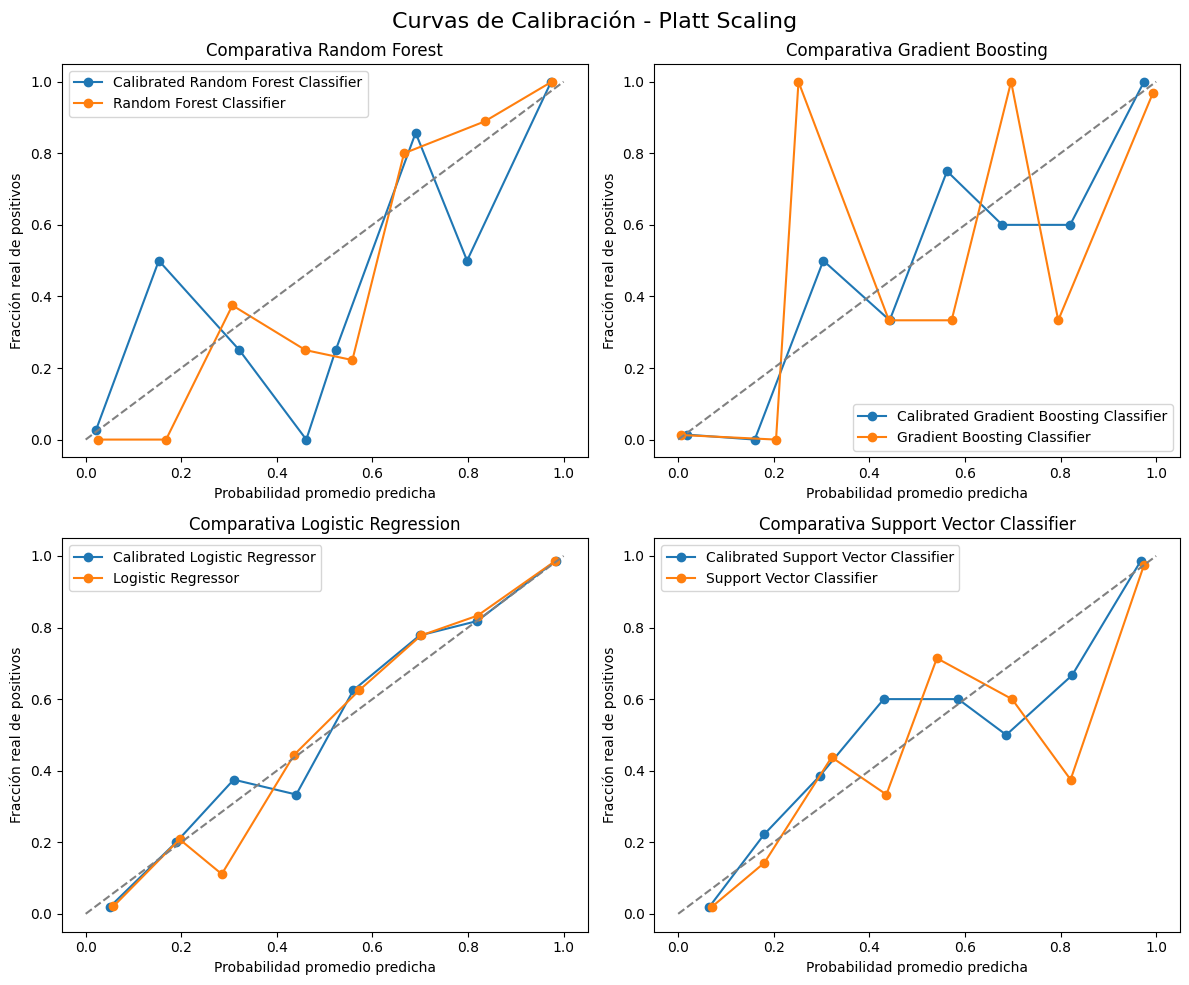

In [227]:
# Obtener las curvas de calibración para cada modelo
fraction_of_positives_rf_calibrated, mean_predicted_value_rf_calibrated = calibration_curve(y_valid, y_prob_calibrated_rf, n_bins=8, strategy='uniform')
fraction_of_positives_xgb_calibrated, mean_predicted_value_xgb_calibrated = calibration_curve(y_valid, y_prob_calibrated_xgb, n_bins=8, strategy='uniform')
fraction_of_positives_lr_calibrated, mean_predicted_value_lr_calibrated = calibration_curve(y_valid, y_prob_calibrated_lr, n_bins=8, strategy='uniform')
fraction_of_positives_svc_calibrated, mean_predicted_value_svc_calibrated = calibration_curve(y_valid, y_prob_calibrated_svc, n_bins=8, strategy='uniform')

# Crear una figura con cuatro subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Curvas de Calibración - Platt Scaling', fontsize=16)

# Configurar el gráfico para el Random Forest
axs[0, 0].plot(mean_predicted_value_rf_calibrated, fraction_of_positives_rf_calibrated, marker='o', label='Calibrated Random Forest Classifier')
axs[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Random Forest Classifier')
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 0].set_title('Comparativa Random Forest')
axs[0, 0].set_xlabel('Probabilidad promedio predicha')
axs[0, 0].set_ylabel('Fracción real de positivos')
axs[0, 0].legend() 

# Configurar el gráfico para el Gradient Boosting
axs[0, 1].plot(mean_predicted_value_xgb_calibrated, fraction_of_positives_xgb_calibrated, marker='o', label='Calibrated Gradient Boosting Classifier')
axs[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', label='Gradient Boosting Classifier')
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 1].set_title('Comparativa Gradient Boosting')
axs[0, 1].set_xlabel('Probabilidad promedio predicha')
axs[0, 1].set_ylabel('Fracción real de positivos')
axs[0, 1].legend() 

# Configurar el gráfico para Logistic Regression
axs[1, 0].plot(mean_predicted_value_lr_calibrated, fraction_of_positives_lr_calibrated, marker='o', label='Calibrated Logistic Regressor')
axs[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', label='Logistic Regressor')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('Comparativa Logistic Regression')
axs[1, 0].set_xlabel('Probabilidad promedio predicha')
axs[1, 0].set_ylabel('Fracción real de positivos')
axs[1, 0].legend() 

# Configurar el gráfico para Support Vector Classifier
axs[1, 1].plot(mean_predicted_value_svc_calibrated, fraction_of_positives_svc_calibrated, marker='o', label='Calibrated Support Vector Classifier')
axs[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', label='Support Vector Classifier')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title('Comparativa Support Vector Classifier')
axs[1, 1].set_xlabel('Probabilidad promedio predicha')
axs[1, 1].set_ylabel('Fracción real de positivos')
axs[1, 1].legend() 

# Ajustar el espacio entre gráficos
plt.tight_layout()

# Mostrar la figura con todos los subgráficos
plt.show()
#

### Isotonic Regression

In [228]:
# Calibrar el modelo lr
calibrated_mode_lr = CalibratedClassifierCV(model_lr, method='isotonic', cv='prefit')
calibrated_mode_lr.fit(X_valid_lr, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_lr_isotonic = calibrated_mode_lr.predict_proba(X_valid_lr)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_lr_c_isotonic = log_loss(y_valid, y_prob_calibrated_lr_isotonic)
brier_lr_c_isotonic = brier_score_loss(y_valid, y_prob_calibrated_lr_isotonic)


# ------------------------------------------------------------

# Calibrar el modelo svc
calibrated_mode_svc = CalibratedClassifierCV(model_svc, method='isotonic', cv='prefit')
calibrated_mode_svc.fit(X_valid_svc, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_svc_isotonic = calibrated_mode_svc.predict_proba(X_valid_svc)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_svc_c_isotonic = log_loss(y_valid, y_prob_calibrated_svc_isotonic)
brier_svc_c_isotonic = brier_score_loss(y_valid, y_prob_calibrated_svc_isotonic)


# ------------------------------------------------------------

# Calibrar el modelo xgb
calibrated_mode_xgb = CalibratedClassifierCV(model_xgb, method='isotonic', cv='prefit')
calibrated_mode_xgb.fit(X_valid_xgb, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_xgb_isotonic = calibrated_mode_xgb.predict_proba(X_valid_xgb)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_xgb_c_isotonic = log_loss(y_valid, y_prob_calibrated_xgb_isotonic)
brier_xgb_c_isotonic = brier_score_loss(y_valid, y_prob_calibrated_xgb_isotonic)


# ------------------------------------------------------------

# Calibrar el modelo rf
calibrated_mode_rf = CalibratedClassifierCV(model_rf, method='isotonic', cv='prefit')
calibrated_mode_rf.fit(X_valid_rf, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_rf_isotonic = calibrated_mode_rf.predict_proba(X_valid_rf)[:, 1]

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_rf_c_isotonic = log_loss(y_valid, y_prob_calibrated_rf_isotonic)
brier_rf_c_isotonic = brier_score_loss(y_valid, y_prob_calibrated_rf_isotonic)


# Calcular ECE para cada caso
ece_rf_c_isotonic = calculate_ece_2(y_valid, y_prob_calibrated_rf_isotonic)
ece_xgb_c_isotonic = calculate_ece_2(y_valid, y_prob_calibrated_xgb_isotonic)
ece_lr_c_isotonic = calculate_ece_2(y_valid, y_prob_calibrated_lr_isotonic)
ece_svc_c_isotonic = calculate_ece_2(y_valid, y_prob_calibrated_svc_isotonic)

indicators_isotonic={'Classifier': ['Calibrated Random Forest Classifier','Calibrated Gradient Boosting Classifier','Calibrated Logistic Regressor','Calibrated Support Vector Classifer'],
            'ECE': [ece_rf_c_isotonic, ece_xgb_c_isotonic, ece_lr_c_isotonic, ece_svc_c_isotonic],
            'Brier Score': [brier_rf_c_isotonic ,brier_xgb_c_isotonic, brier_lr_c_isotonic,brier_svc_c_isotonic],
            'Log Loss': [logloss_rf_c_isotonic ,logloss_xgb_c_isotonic, logloss_lr_c_isotonic,logloss_svc_c_isotonic]}
indicators_df_isotonic = pd.DataFrame(indicators_isotonic)
indicators_df_isotonic

,Classifier,ECE,Brier Score,Log Loss
0,Calibrated Random Forest Classifier,0.000000e+00,0.030431,0.089757
1,Calibrated Gradient Boosting Classifier,8.180591e-18,0.029407,0.091648
2,Calibrated Logistic Regressor,1.453516e-17,0.065768,0.200530
3,Calibrated Support Vector Classifer,1.111684e-16,0.073396,0.225455


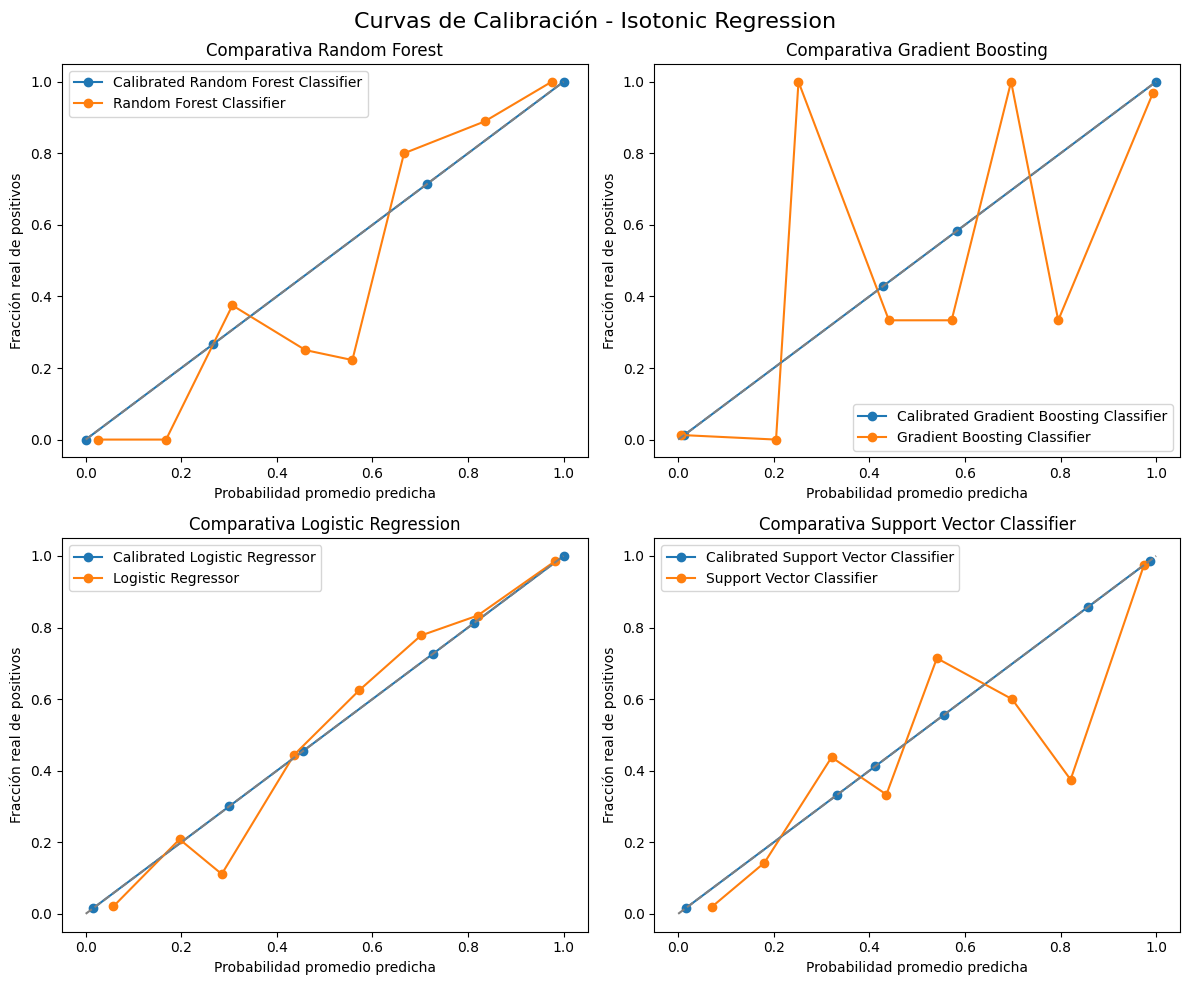

In [229]:
# Obtener las curvas de calibración para cada modelo
fraction_of_positives_rf_calibrated_isotonic, mean_predicted_value_rf_calibrated_isotonic = calibration_curve(y_valid, y_prob_calibrated_rf_isotonic, n_bins=8, strategy='uniform')
fraction_of_positives_xgb_calibrated_isotonic, mean_predicted_value_xgb_calibrated_isotonic = calibration_curve(y_valid, y_prob_calibrated_xgb_isotonic, n_bins=8, strategy='uniform')
fraction_of_positives_lr_calibrated_isotonic, mean_predicted_value_lr_calibrated_isotonic = calibration_curve(y_valid, y_prob_calibrated_lr_isotonic, n_bins=8, strategy='uniform')
fraction_of_positives_svc_calibrated_isotonic, mean_predicted_value_svc_calibrated_isotonic = calibration_curve(y_valid, y_prob_calibrated_svc_isotonic, n_bins=8, strategy='uniform')

# Crear una figura con cuatro subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Curvas de Calibración - Isotonic Regression', fontsize=16)
# Configurar el gráfico para el Random Forest
axs[0, 0].plot(mean_predicted_value_rf_calibrated_isotonic, fraction_of_positives_rf_calibrated_isotonic, marker='o', label='Calibrated Random Forest Classifier')
axs[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Random Forest Classifier')
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 0].set_title('Comparativa Random Forest')
axs[0, 0].set_xlabel('Probabilidad promedio predicha')
axs[0, 0].set_ylabel('Fracción real de positivos')
axs[0, 0].legend() 

# Configurar el gráfico para el Gradient Boosting
axs[0, 1].plot(mean_predicted_value_xgb_calibrated_isotonic, fraction_of_positives_xgb_calibrated_isotonic, marker='o', label='Calibrated Gradient Boosting Classifier')
axs[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', label='Gradient Boosting Classifier')
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 1].set_title('Comparativa Gradient Boosting')
axs[0, 1].set_xlabel('Probabilidad promedio predicha')
axs[0, 1].set_ylabel('Fracción real de positivos')
axs[0, 1].legend() 

# Configurar el gráfico para Logistic Regression
axs[1, 0].plot(mean_predicted_value_lr_calibrated_isotonic, fraction_of_positives_lr_calibrated_isotonic, marker='o', label='Calibrated Logistic Regressor')
axs[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', label='Logistic Regressor')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('Comparativa Logistic Regression')
axs[1, 0].set_xlabel('Probabilidad promedio predicha')
axs[1, 0].set_ylabel('Fracción real de positivos')
axs[1, 0].legend() 

# Configurar el gráfico para Support Vector Classifier
axs[1, 1].plot(mean_predicted_value_svc_calibrated_isotonic, fraction_of_positives_svc_calibrated_isotonic, marker='o', label='Calibrated Support Vector Classifier')
axs[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', label='Support Vector Classifier')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title('Comparativa Support Vector Classifier')
axs[1, 1].set_xlabel('Probabilidad promedio predicha')
axs[1, 1].set_ylabel('Fracción real de positivos')
axs[1, 1].legend() 

# Ajustar el espacio entre gráficos
plt.tight_layout()

# Mostrar la figura con todos los subgráficos
plt.show()